In [1]:
!pip install datasets
!pip install faiss-cpu sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 85.8 MB/s eta 0:00:00


In [3]:
import torch
import gc
import faiss
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration
import plot

In [4]:
!git clone https://github.com/brendenlake/SCAN.git

Cloning into 'SCAN'...
remote: Enumerating objects: 205, done.
remote: Total 205 (delta 0), reused 0 (delta 0), pack-reused 205 (from 1)
Receiving objects: 100% (205/205), 11.10 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (173/173), done.


In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = T5Tokenizer.from_pretrained("t5-small")
tokenizer.model_max_length = 1024
embed_model = SentenceTransformer('all-MiniLM-L6-v2').to(DEVICE)
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(DEVICE)

K_EXAMPLES = 5

model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [6]:
BATCH_SIZE = 32

train_path = "/content/SCAN/length_split/tasks_train_length.txt"
test_path = "/content/SCAN/length_split/tasks_test_length.txt"

In [ ]:
commands = []
pred_actions = []
gold_actions = []

train_inputs, train_outputs = [], []
with open(train_path, 'r') as f:
    for line in f:
        parts = line.strip().split(" OUT: ")
        src = parts[0].replace("IN: ", "")
        train_inputs.append(src)


        train_outputs.append(parts[1])


print("Encoding Training Pool...")
train_embeddings = embed_model.encode(train_inputs, show_progress_bar=True, convert_to_numpy=True)


dimension = train_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(train_embeddings.astype('float32'))


seq_corr, tok_sum, count = 0, 0, 0

print("Indexing Training Pool...")
train_embs = embed_model.encode(train_inputs, batch_size=128, show_progress_bar=True)
index = faiss.IndexFlatL2(train_embs.shape[1])
index.add(train_embs.astype('float32'))


test_cmds = []
test_targets = []
with open(test_path, 'r') as f:
    for line in f:
        parts = line.strip().split(" OUT: ")
        test_src = parts[0].replace("IN: ", "")
        test_cmds.append(test_src)
        test_targets.append(parts[1])

print("Encoding Test Queries...")
test_embs = embed_model.encode(test_cmds, batch_size=128, show_progress_bar=True)


print("Searching FAISS Index...")
_, all_indices = index.search(test_embs.astype('float32'), K_EXAMPLES)

seq_corr, tok_sum, count = 0, 0, 0
pred_actions, gold_actions, commands = [], [], []

for i in tqdm(range(0, len(test_cmds), BATCH_SIZE), desc="Word-Perfect Oracle"):
    batch_cmds = test_cmds[i : i + BATCH_SIZE]
    batch_targets = test_targets[i : i + BATCH_SIZE]
    batch_indices = all_indices[i : i + BATCH_SIZE]

    target_word_counts = [len(t.split()) for t in batch_targets]

    prompts = []
    for j, test_cmd in enumerate(batch_cmds):
        prompt = "Translate SCAN to actions:\n"
        for train_idx in batch_indices[j]:
            prompt += f"{train_inputs[train_idx]} -> {train_outputs[train_idx]} |\n "
        prompt += f"{test_cmd} ->"
        prompts.append(prompt)

    inputs = tokenizer(prompts, padding=True, return_tensors="pt").to(DEVICE)


    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            num_beams=1,
            do_sample=False
        )

    preds_raw = tokenizer.batch_decode(outputs, skip_special_tokens=True)


    preds = []
    for raw_pred, target_len in zip(preds_raw, target_word_counts):
        words = raw_pred.strip().split()

        if len(words) < target_len:
            words.extend(["<MISSING>"] * (target_len - len(words)))

        truncated_words = words[:target_len]
        preds.append(" ".join(truncated_words))

    with open("exp2b_examples.txt", 'a') as f:
        for k in range(len(preds)):
            f.write(f"\n[Test Sample {i + k}]\n")
            f.write(f"PROMPT:\n{prompts[k]}\n")
            f.write(f"INPUT CMD:  {batch_cmds[k]}\n")
            f.write(f"PREDICTION: {preds[k]}\n")
            f.write(f"TARGET:     {batch_targets[k]}\n")
            f.write("-" * 70 + "\n")

    for pred, target, current_cmd in zip(preds, batch_targets, batch_cmds):
        if pred == target:
            seq_corr += 1

        pred_actions.append(pred)
        gold_actions.append(target)
        commands.append(current_cmd)

        p_toks, t_toks = pred.split(), target.split()
        matches = sum(1 for p, t in zip(p_toks, t_toks) if p == t)
        tok_sum += (matches / len(t_toks))
        count += 1

print(f"Results -> Exact: {seq_corr/count:.4f}, Token Acc: {tok_sum/count:.4f}")


del outputs, inputs
gc.collect()
torch.cuda.empty_cache()

Encoding Training Pool...


Batches:   0%|          | 0/531 [00:00<?, ?it/s]

Indexing Training Pool...


Batches:   0%|          | 0/133 [00:00<?, ?it/s]

Encoding Test Queries...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Searching FAISS Index...


Word-Perfect Oracle: 100%|██████████| 123/123 [03:19<00:00,  1.62s/it]


Results -> Exact: 0.0000, Token Acc: 0.2134


In [25]:
results = plot.compute_accuracies_ex2(
    commands=commands,
    gold_actions=gold_actions,
    pred_actions=pred_actions
)

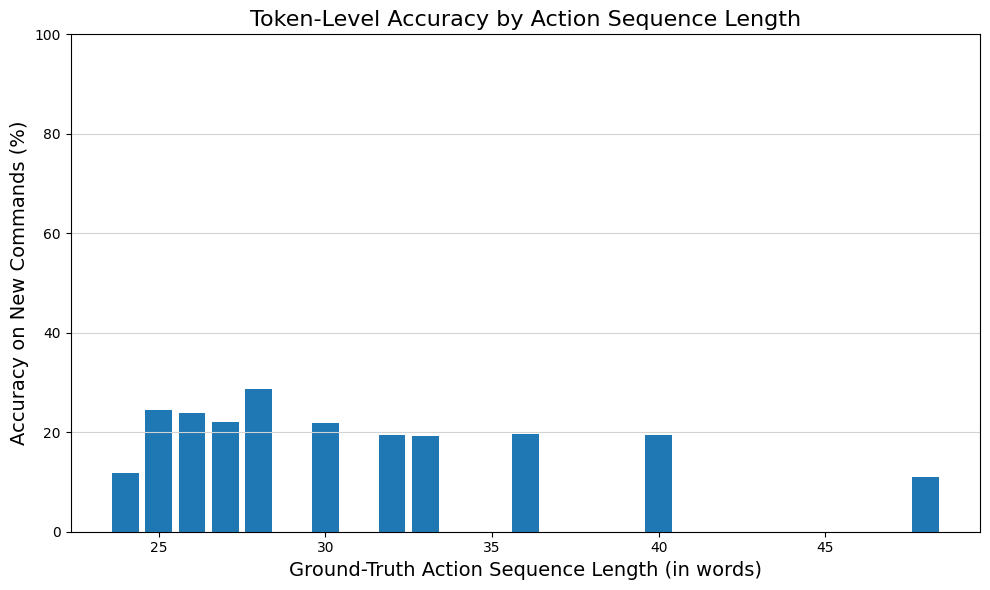

<Figure size 640x480 with 0 Axes>

In [26]:
plot.plot_ex2_tokenAccSeqLength(
    results["action_lengths"], results["token_accuracy_by_action_length"]
)

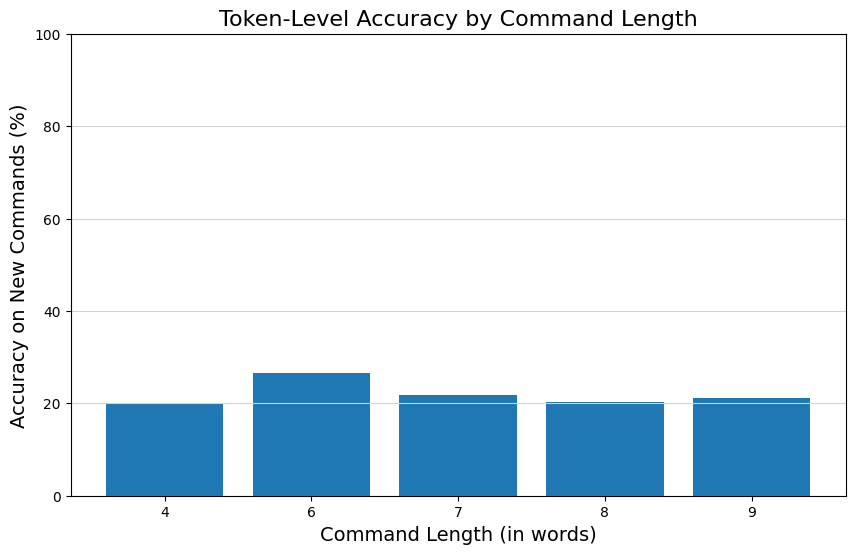

<Figure size 640x480 with 0 Axes>

In [27]:
plot.plot_ex2_tokenAccCommandLength(
    results["command_lengths"], results["token_accuracy_by_command_length"]
)